In [1]:
import scipy.io as sio
import numpy as np
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import pylab

In [2]:
# Load data, the data used in this script is MNIST data set.
# The object 'data' is a dic that contains np.array 'trainX', whose last column is label.
matfn='train.mat'
data=sio.loadmat(matfn)

In [3]:
n_feature=data['trainX'].shape[1]-1
label=np.unique(data['trainX'][...,n_feature])

In [4]:
# Standardize data
norm=np.repeat(np.apply_along_axis(np.linalg.norm,1,data['trainX'][...,0:n_feature]),n_feature).reshape(len(data['trainX']),n_feature)
data_norm=data['trainX'][...,0:n_feature]/norm

In [5]:
# Split the training set and validation set
i=True
while i is True:
    valid_ind=random.sample(range(len(data_norm)),10000)
    train_ind=[i for i in range(len(data_norm)) if i not in valid_ind]    
    valid_set=data_norm[valid_ind]
    train_set=data_norm[train_ind]
    valid_label=data['trainX'][...,n_feature][valid_ind]
    train_label=data['trainX'][...,n_feature][train_ind]        
    i= (False in [i in valid_label for i in label]) | (False in [i in train_label for i in label])

In [1]:
def get_mu(data_set,data_label,n_class): 
    """
    :data_set: np.array
    :data_label: np.array
    :n_class: int
    """
    mu=[]
    for i in range(n_class):
        mu.append(np.apply_along_axis(np.mean,0,data_set[data_label==i]))
    return mu

In [7]:
def get_sigma(data_set,data_label,mu,n_feature,n_class):
    """
    :data_set: np.array
    :data_label: np.array
    :mu: np.array
    :n_feature: int
    :n_class: int
    """
    sigma=[]
    for i in range(n_class):
        sigma_i=np.mat(np.zeros((n_feature,n_feature)))
        for x in data_set[data_label==i]:
            sigma_i=sigma_i+np.mat(x-mu[i]).T*np.mat(x-mu[i])
        sigma.append(sigma_i/len(data_set[data_label==i]))
    sigma_LDA=np.mat(np.zeros((len(sigma[0]),len(sigma[0]))))
    for i in range(n_class):
        sigma_LDA=sigma_LDA+sigma[i]*len(data_set[data_label==i])
    sigma_LDA=sigma_LDA/len(data_set)
    sigma_total={'sigma':sigma,'sigma_LDA':sigma_LDA}
    return sigma_total

In [8]:
def get_pi(data_set,data_label):
    """
    :data_set: np.array
    :data_label: np.array
    """
    pi=[]
    for i in range(10):
        pi.append(len(data_set[data_label==i])/len(data_set))
    return pi

In [ ]:
def fit_model(data_set,data_label,n_feature,n_class):
    """
    :data_set: np.array
    :data_label: np.array
    :n_feature: int
    :n_class: int
    """
    mu=get_mu(data_set,data_label,n_class)
    sigma=get_sigma(data_set,data_label,mu,n_feature,n_class)
    pi=get_pi(data_set,data_label)
    parameters={'mu':mu,'sigma':sigma['sigma'],'sigma_LDA':sigma['sigma_LDA'],'pi':pi}
    return parameters

In [ ]:
# Get estimated parameters (MLE).
parameters=fit_model(train_set, train_label,n_feature,len(label))

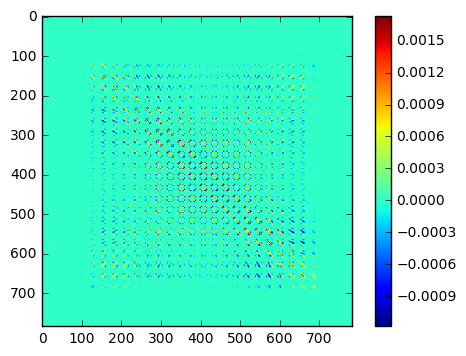

In [23]:
# Plot SD matrix.
pylab.imshow(np.array(parameters['sigma'][0]))
pylab.colorbar()
pylab.show()

In [62]:
def LDA_prediction(parameters,data_set,alpha):
    """
    :parameters: dic
    :data_set: np.array
    :alpha: int
    """   
    n_feature=data_set.shape[1]
    n_class=len(parameters['mu'])
    sigma_LDA_I=(parameters['sigma_LDA']+np.diag(np.repeat(alpha,n_feature))).I
    def pre_LDA(x):   
        pos=[]
        for i in range(n_class):
            pos_i=np.mat(parameters['mu'][i])*sigma_LDA_I*np.mat(x).T-0.5*np.mat(parameters['mu'][i])*sigma_LDA_I*np.mat(parameters['mu'][i]).T+np.log(parameters['pi'][i])
            pos.append(pos_i)
        prediction=range(n_class)[pos.index(max(pos))]
        return prediction
    LDA=np.apply_along_axis(pre_LDA,1,data_set)
    return LDA

In [78]:
# Predict validation labels.
LDA=LDA_prediction(parameters,valid_set,0.001)

In [76]:
def error_rate(predition,True_value):
    """
    :predition: np.array
    :True_value: np.array
    """     
    error=1-(predition==True_value).sum()/len(predition)
    return error

In [79]:
error_rate(LDA,valid_label)

0.12390000000000001

In [156]:
def QDA_prediction(parameters,data_set,alpha):
    """
    :parameters: dic
    :data_set: np.array
    :alpha: int
    """   
    n_feature=data_set.shape[1]
    n_class=len(parameters['mu'])
    pos=[]
    for i in range(n_class):
        pos_i=stats.multivariate_normal.logpdf(data_set,parameters['mu'][i],parameters['sigma'][i]+np.diag(np.repeat(alpha,n_feature)))+np.log(parameters['pi'][i])
        pos.append(pos_i)
    QDA=[]
    for i in range(len(data_set)):
        QDA.append(range(n_class)[np.mat(pos).T[i].tolist()[0].index(max(np.mat(pos).T[i].tolist()[0]))])    
    return QDA

In [162]:
QDA=QDA_prediction(parameters,valid_set,0.001)

In [163]:
error_rate(QDA,valid_label)

0.045399999999999996